# 1. 개요 (Introduction)

분류 모델의 경우 어떠한 Data가 들어와도 좋은 결과를 낼수 있으면서 Simple한 모델을 만들기 위하여 
데이터가 적어 결과를 빨리 볼수 있는 타이타닉 Data를 활용하여 모델링 작업을 실행해 보겠습니다.

(In the case of classification models, 
in order to create a simple model while producing good results no matter what data comes in, 
I will use Titanic Data, which has little data, so we can quickly see the results)

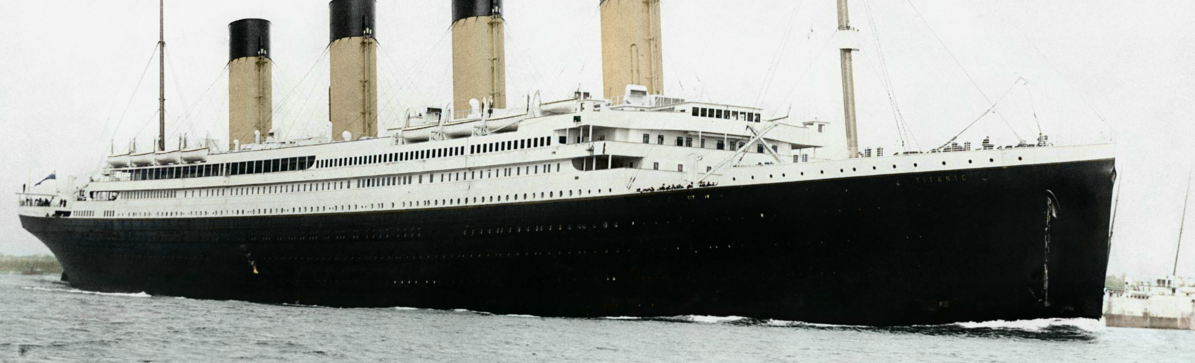

초기 모델은 LightGBM을 사용하여 모델링 진행하였고, 이것에 대한 설명은 하단의 싸이트에 자세히 나와 있습니다. 
(The initial model was modeled using LightGBM, and the description of this is detailed on the site below.)
https://lightgbm.readthedocs.io/en/latest

파라메터 검색방법은 ① 상단의 싸이트 들어가서, ② 왼쪽 메뉴중 "Parameters" 선택 , ③ Core Parameters를 보시면 
Hyper Parameter Tuning에 대한 팁을 얻으실수 있습니다. 
(For parameter search methods, go to the site, select "Parameters" from the left menu, and see Core Parameters to get tips on Hyper Parameter Tuning.)

# 2. 데이터 불러오기(Read Dataset) 및 EDA
 
아래와 같이 데이터 분석 및 Data 전처리 예정입니다.
(Data analysis and data preprocessing will be conducted as below.)
 - Outliers (Missing값을 대체 할때 평균을 사용할 수도 있기 때문에 먼저 시행합니다.)
 - Encoding(x,y값을 나눠야 하기에 뒤에서 할 수 있음) + Missing Values(encoding 된 값을 사용할 수도 있어서 둘이 함께 작업함)
 - Feature Scaling
 - Feature Extraction
 - Feature Interactions
 
상기 분석은 하단의 싸이트를 참조하여 분석 하였습니다.
(The above analysis was conducted by referring to the site at the bottom.)
https://www.kaggle.com/seneralkan/advanced-feature-engineering

In [ ]:
import datetime
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import QuantileTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [ ]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

In [ ]:
# data type을 보고, 그에 맞춰서 그래프 분석을 시행할 겁니다.
df_train.info()

기본적으로 boxplot을 그려 Outlier가 얼마나 있는지 확인해 보고, 이부분에 대하여 전처리 시행합니다.
(Basically, draw a boxplot to check how many outliers there are, and preprocess this part.)

In [ ]:
sns.boxplot(df_train["Age"])

In [ ]:
sns.boxplot(df_train["Fare"])

1분위수와 3분위수를 기준 값을 구하는 함수를 만들고, 이것을 outlier에 적용하는 로직을 만듭니다. 
(Create a function to find the reference values for the first and third quartiles, and create a logic that applies them to outliers.)

In [ ]:
def outlier_replace(data, col_name, q1=0.25, q3=0.75):
    quartile1 = data[col_name].quantile(q1)
    quartile3 = data[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    data.loc[(data[col_name] < low_limit), col_name] = low_limit
    data.loc[(data[col_name] > up_limit), col_name] = up_limit

In [ ]:
outlier_replace(df_train, 'Age')
outlier_replace(df_train, 'Fare')
outlier_replace(df_test, 'Age')
outlier_replace(df_test, 'Fare')

In [ ]:
def missing_values_table(dataframe, na_name=False):
    # null값이 1개 이상 있는 column 추출
    # The columns name that contains missing value
    null_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[null_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[null_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return null_columns
    
missing_values_table(df_train, True)

In [ ]:
df_train["Age"].fillna(df_train["Age"].median())
df_test["Age"].fillna(df_test["Age"].median())

df_train = df_train.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
df_test = df_test.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)

df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])

df_train.isnull().sum().sort_values(ascending=False)

In [ ]:
df_train=df_train.drop(['Name','Ticket'],axis=1)
df_test=df_test.drop(['Name','Ticket'],axis=1)

In [ ]:
cat_cols = [col for col in df_train.columns if df_train[col].dtype not in ["float16","float32","float64","int"]]
y = df_train["Survived"].copy()
y_nm = 'Survived'
train_y = pd.DataFrame(df_train[y_nm])

train_x = df_train.drop(y_nm, axis = 1)
train_y = pd.DataFrame(df_train[y_nm])

test_x = df_test

for cols in cat_cols:
    enc = TargetEncoder(cols=[cols])
    train_x = enc.fit_transform(train_x, y)
    test_x = enc.transform(test_x)

df_train = pd.concat([train_x, train_y], axis=1) 

스케일링 종류 (Type of feature scaling): 
 - StandardScaler: SND를 따름. 평균은 0/ 식은 z = (x - u) / s
 - RobustScaler: 1/3분위수를 활용한 강력한 통계방식/ value = (value – median)/ (p75(3분위) – p25(1분위))
 - MinMaxScaler: X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)), X_scaled = X_std * (max - min) + min
 - Logaritmic Scaler: 로그를 사용/ 음수 사용 불가 감안 사용시 주의가 필요
(Taking the log of the value. But, if we have a negative values we couldn't take the log. So we need to be careful abaout it.)

In [ ]:
# Scaling the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(scaler.fit_transform(test_x), columns=test_x.columns)
df_train.head()

In [ ]:
def new_col(df):
    df["NEW_FAMILY_SIZE"] = df["SibSp"] + df["Parch"] + 1
    df["NEW_AGExPCLASS"] = df["Age"] * df["Pclass"]
    df.loc[((df['SibSp'] + df['Parch']) > 0), "NEW_IS_ALONE"] = "NO"
    df.loc[((df['SibSp'] + df['Parch']) == 0), "NEW_IS_ALONE"] = "YES"
    
new_col(df_train)
new_col(df_test)

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [ ]:
random_state_val =777
test_size_val =0.3

df_train, df_val = train_test_split(df_train, test_size = test_size_val, random_state = random_state_val)

drop_col = ['Survived', 'PassengerId']
y_nm = 'Survived'

df_train_x = df_train.drop(drop_col, axis = 1)
df_train_y = pd.DataFrame(df_train[y_nm])

df_val_x = df_val.drop(drop_col, axis = 1)
df_val_y = pd.DataFrame(df_val[y_nm])

# 3.모델링(Modeling)

In [ ]:
LGBClassifier = lgb.LGBMClassifier(objective='binary',
                                   max_depth = 8,
                                   learning_rate = 0.01,
                                   n_estimators = 9000,
                                   max_bin = 200,
                                   bagging_freq = 4,
                                   bagging_seed = 8,
                                   feature_fraction = 0.2,
                                   feature_fraction_seed = 8,
                                   min_sum_hessian_in_leaf = 11,
                                   verbose = -1,
                                   random_state = 42)

In [ ]:
start = datetime.datetime.now()
lgbm = LGBClassifier.fit(df_train_x.values,
                       df_train_y.values.ravel(),
                       eval_set = [(df_train_x.values, df_train_y), (df_val_x.values, df_val_y)],
                       eval_metric ='logloss',
                       early_stopping_rounds = 20,
                       verbose =False)
end = datetime.datetime.now()
end-start

In [ ]:
feature_imp= pd.DataFrame(sorted(zip(lgbm.feature_importances_, df_train_x.columns), reverse = True), columns = ['Value', 'Feature'])
# feature_imp.to_excel("feature_imp.xlsx")

plt.figure(figsize=(7,5))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False))
plt.tight_layout()
plt.show()
# plt.savefig('lightGBM_ Importances.png')

In [ ]:
result_lst =[]
max_accuracy =0.
opt_threshold =0.
val_y_prob = lgbm.predict_proba(df_val_x.values)[:, 1]

for n in range(0,60):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    pred_yn = np.where(pred_yn > threshold, 1., 0.)
    
    result_dict = {}
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)
    
    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)
    
    if max_accuracy <= accuracy:
        max_accuracy = accuracy
        opt_threshold = threshold
        
    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])
    
matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score', 'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('최고 Accuracy-SCORE =%f, 임계치=%f'%(max_accuracy, opt_threshold))
print('Threshold 설정 완료')

In [ ]:
predict_lgbm = lgbm.predict_proba(df_train_x.values)[:,1]
pred_train = np.where(predict_lgbm > opt_threshold, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_train_y.values.ravel(), pred_train, labels=[1,0]).ravel()

In [ ]:
conf_matrix = pd.DataFrame(
    confusion_matrix(df_train_y.values.ravel(), pred_train),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_train_y.values.ravel(), pred_train))

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_train_y.values.ravel(), predict_lgbm)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

LightGBM만 사용하여 이미 0.78의 Best Score를 달성하였습니다. 
하지만, 이것이 과적합이되어 해당 값이 나온 것인지 알수 없고, 데이터 자체가 너무 적기 때문에 다른 참가자들의 코드를 참고하여 모델링 해보았습니다.
(I have already achieved a best score of 0.78 using only LightGBM.
However, I don't know if this was overfitting and the value came out, and because the data itself was too small, I modeled it with reference to other participants' codes.)

In [ ]:
df_test = df_test.drop(['PassengerId'], axis = 1)

predict_lgbm = lgbm.predict_proba(df_test.values)[:,1]
pred_test = np.where(predict_lgbm > opt_threshold, 1., 0.)

# test_result= pd.DataFrame(pred_test)
# test_result.columns = ['Survived']
# predict = test_result['Survived']
# df_test = pd.read_csv('../input/titanic/test.csv')
# Id_No = df_test['PassengerId']
# submission = pd.DataFrame({'PassengerId': Id_No, "Survived": predict})
# submission['Survived'] = submission['Survived'].astype('Int64')
# submission.to_csv('submission.csv', index=False)

model_score = lgbm.score(df_train_x.values, df_train_y.values.ravel())
print("Model Score : {:.2f} %".format(model_score * 100))

하단은 https://www.kaggle.com/lovroselic/titanic-ls#Predictions 을 참조하여 모델링 하였습니다.
(The bottom was modeled by referring to https://www.kaggle.com/lovroselic/titanic-ls#Predictions.)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

drop_col = ['Survived', 'PassengerId']
y_nm = 'Survived'

df_train_x = df_train.drop(drop_col, axis = 1)
df_train_y = pd.DataFrame(df_train[y_nm])
# df_test = df_test.drop(['PassengerId'], axis = 1)

rf_model = RandomForestClassifier(max_depth=5, n_estimators= 9000, random_state=42)
rf_model.fit(df_train_x.values, df_train_y.values.ravel())
model_score = rf_model.score(df_train_x.values, df_train_y.values.ravel())
print("Model Score : {:.2f} %".format(model_score * 100))

In [ ]:
from sklearn.svm import SVC

SVM_model = SVC(C = 100, gamma= 0.01, kernel='rbf')
SVM_model.fit(df_train_x.values, df_train_y.values.ravel())
model_score = SVM_model.score(df_train_x.values, df_train_y.values.ravel())
print("Model Score : {:.2f} %".format(model_score * 100))

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(learning_rate= 0.2, max_depth=4, n_estimators=75, reg_lambda=0.5, subsample= 0.5, use_label_encoder=False, eval_metric='logloss') #0,843
xgb_model.fit(df_train_x.values, df_train_y.values.ravel())
model_score = xgb_model.score(df_train_x.values, df_train_y.values.ravel())
print("Model Score : {:.2f} %".format(model_score * 100))

In [ ]:
df_test2 = pd.read_csv('../input/titanic/test.csv')
Id_No = df_test2['PassengerId']

lgbm_predict = lgbm.predict(df_test.values)
xgb_predict = xgb_model.predict(df_test.values) 
rf_predict = rf_model.predict(df_test.values) 
svm_predict = SVM_model.predict(df_test.values) 

def vote(votes):
    weight_dict = {'LGBM':1,'XGB':1,'RF':1,"SVM":1}
    weights = np.array(list(weight_dict.values()))
    sw = weights.sum()
    v = [v * weights[i] for i,v in enumerate(votes)]
    return sum(v)/ sw

all_predict = pd.DataFrame({'PassengerId': Id_No,
                            'LGBM': lgbm_predict, 'XGB': xgb_predict, 'RF':rf_predict, "SVM":svm_predict})
clfs = ['LGBM','XGB','RF',"SVM"]
all_predict['Vote'] = all_predict[clfs].apply(lambda row: vote(row), axis = 1)
all_predict['Predict'] = all_predict.Vote.apply(lambda row: int(np.rint(row)))
vc_predictions = all_predict.Predict
all_predict.head(10)

In [ ]:
submission = pd.DataFrame({'PassengerId': Id_No, 'Survived': vc_predictions})
submission['Survived'] = submission['Survived'].astype('Int64')
submission.to_csv('submission.csv', index=False)
submission.head(10)